<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/Base_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
from sklearn.metrics import confusion_matrix
import ast

# Access Dataset via Kaggle API
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem.

In [2]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
 99% 1.61G/1.62G [00:14<00:00, 94.9MB/s]
100% 1.62G/1.62G [00:14<00:00, 119MB/s] 


# Loading the Dataset

In [3]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Dataset Information

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Splitting the Data

In [5]:
print(type(df_data['target'].iloc[0]))


<class 'str'>


In [6]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training, test and validation sets
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

# Data Distribution
- Class imbalance, we have minority classes M, H, G, C, A.

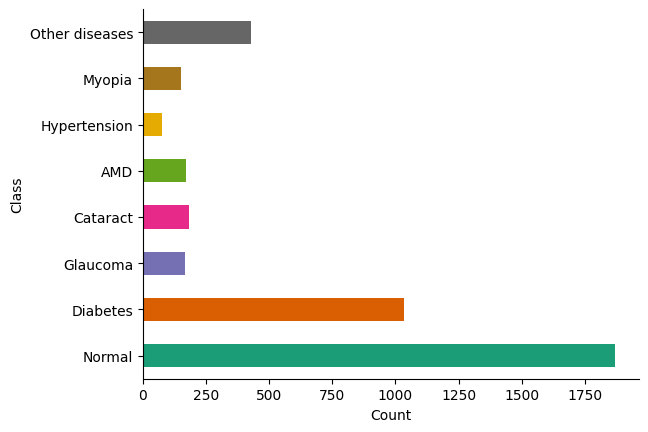

In [7]:
# @title Distribution of Training Data
# Define the class names
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
train_df['class_name'] = train_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = train_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

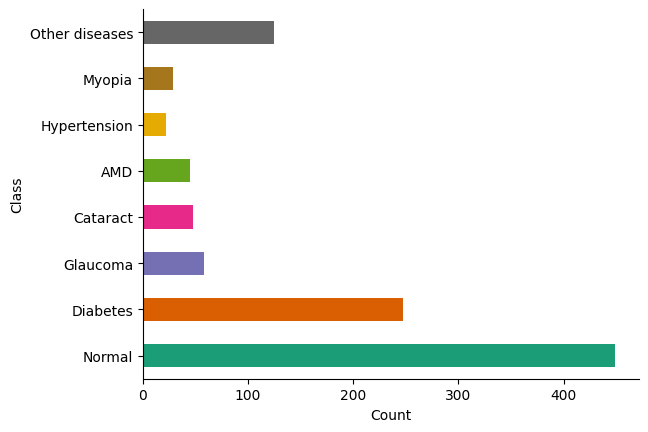

In [8]:
# @title Distribution of Validation Data
# Define the class names
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
val_df['class_name'] = val_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = val_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

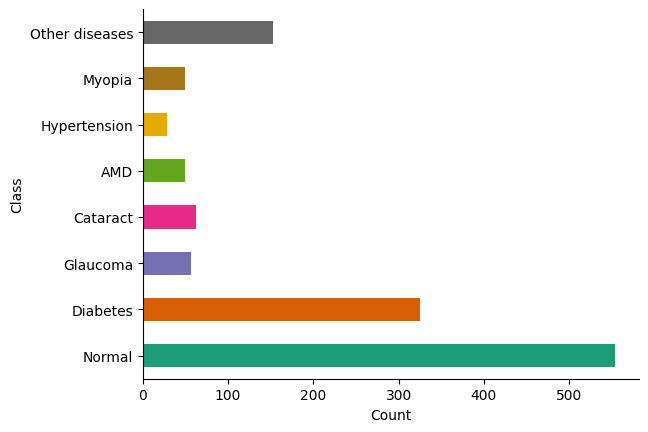

In [9]:
# @title Distribution of Test Data
# Define the class names
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
test_df['class_name'] = test_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = test_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

# Data Preparation

Image Preprocessing

In [10]:
# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    # Assuming label_string is the string representation of the list (e.g., "[1, 0, 0]")
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

Preparing Test and Validation Datasets

In [12]:
def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):


    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


# Creating training and validation datasets
train_ds = load_and_prepare_dataset(train_df , 'ODIR-5K/ODIR-5K/Training Images/', shuffle=True, batch_size=16)
test_ds = load_and_prepare_dataset(test_df, 'ODIR-5K/ODIR-5K/Training Images/',shuffle=False, batch_size=16)
val_ds = load_and_prepare_dataset(val_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=16)


Size of Datasets

In [13]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))
print("size of testing dataset: ", len(test_ds) )

size of training dataset:  512
size of validation dataset:  128
size of testing dataset:  160


# Visualising the training and validation datasets




Training dataset
(16, 224, 224, 3)
(16, 8)


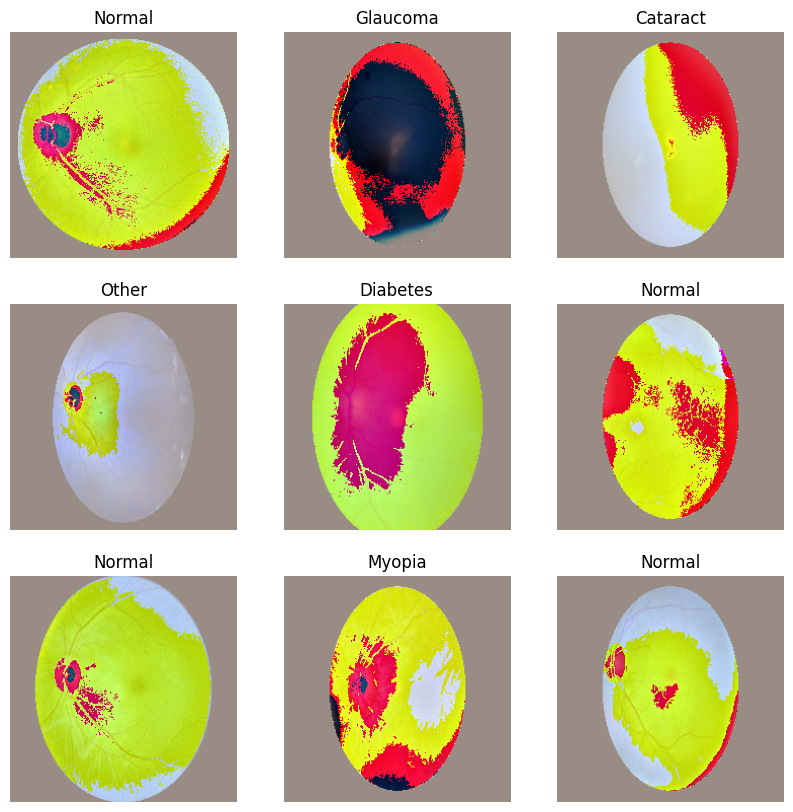

In [14]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(16, 224, 224, 3)
(16, 8)


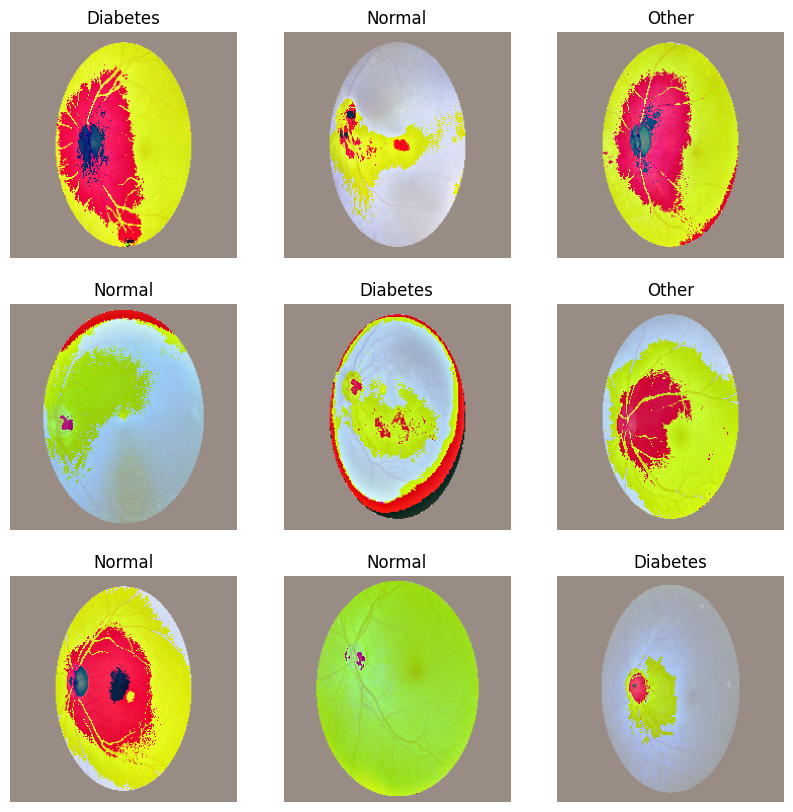

In [15]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

In [16]:
# Calculate class weights
def get_class_weights(labels):
    total_samples = len(labels)
    n_classes = len(labels[0])
    class_counts = np.zeros(n_classes)
    for label in labels:
        class_counts += label
    class_weights = total_samples / (n_classes * class_counts)
    return class_weights

# Get the labels from the training dataset
train_labels = []
for _, labels in train_ds:
    train_labels.append(labels.numpy())
train_labels = np.concatenate(train_labels)

# Calculate class weights
class_weights = get_class_weights(train_labels)
print("Class weights:", class_weights)

# Assuming class_weights is the array returned by your function
class_weights_array = get_class_weights(train_labels)

# Convert this array into a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights dictionary:", class_weights_dict)

Class weights: [0.27339572 0.49348456 3.02514793 2.79371585 2.98976608 6.55448718
 3.34150327 1.18895349]
Class weights dictionary: {0: 0.2733957219251337, 1: 0.493484555984556, 2: 3.025147928994083, 3: 2.7937158469945356, 4: 2.989766081871345, 5: 6.55448717948718, 6: 3.3415032679738563, 7: 1.188953488372093}


# Training the model

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = [early_stopping, checkpoint, reduce_lr]

In [18]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 24114312 (91.99 MB)
Trainable params: 526600 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


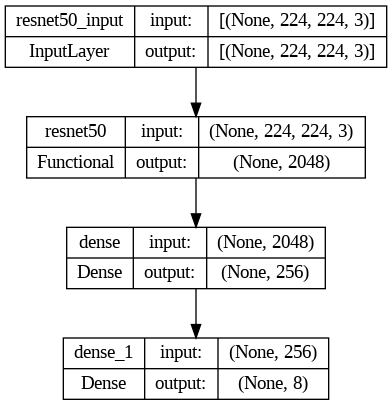

In [20]:
from tensorflow.keras.utils import plot_model
# Plot the model architecture graphically
plot_model(model, to_file='model_summary.png', show_shapes=True)

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/50
512/512 [==============================] - ETA: 0s - loss: 1.3336 - accuracy: 0.5054
Epoch 1: val_loss improved from inf to 1.32042, saving model to best_model
512/512 [==============================] - 71s 94ms/step - loss: 1.3336 - accuracy: 0.5054 - val_loss: 1.3204 - val_accuracy: 0.5068 - lr: 0.0010
Epoch 2/50
512/512 [==============================] - ETA: 0s - loss: 1.1911 - accuracy: 0.5544
Epoch 2: val_loss did not improve from 1.32042
512/512 [==============================] - 46s 58ms/step - loss: 1.1911 - accuracy: 0.5544 - val_loss: 1.3333 - val_accuracy: 0.5132 - lr: 0.0010
Epoch 3/50
511/512 [============================>.] - ETA: 0s - loss: 1.1451 - accuracy: 0.5696
Epoch 3: val_loss improved from 1.32042 to 1.25935, saving model to best_model
512/512 [==============================] - 63s 92ms/step - loss: 1.1453 - accuracy: 0.5694 - val_loss: 1.2594 - val_accuracy: 0.5196 - lr: 0.0010
Epoch 4/50
511/512 [============================>.] - ETA: 0s - loss: 1.0

# Evaluating Model
- Model Accuracy
- Model Loss


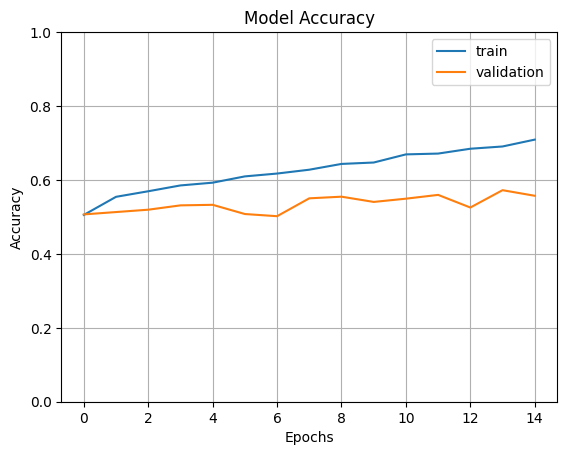

In [23]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

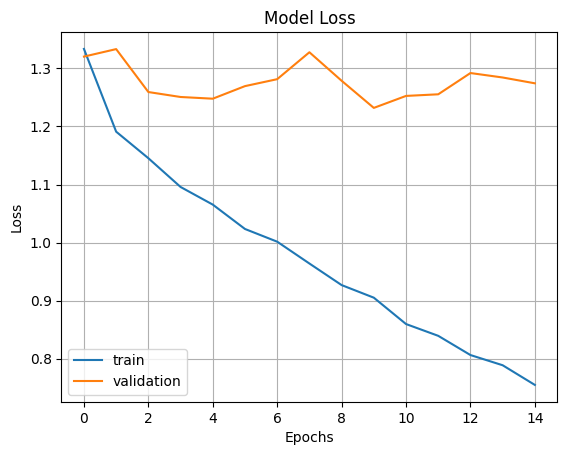

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions


In [25]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')

160/160 [==============================] - 9s 55ms/step - loss: 1.2288 - accuracy: 0.5547
Test accuracy: 55.47%


160/160 [==============================] - 8s 50ms/step - loss: 1.2288 - accuracy: 0.5547
Evaluation results: [1.2287923097610474, 0.554730236530304]
160/160 [==============================] - 10s 54ms/step


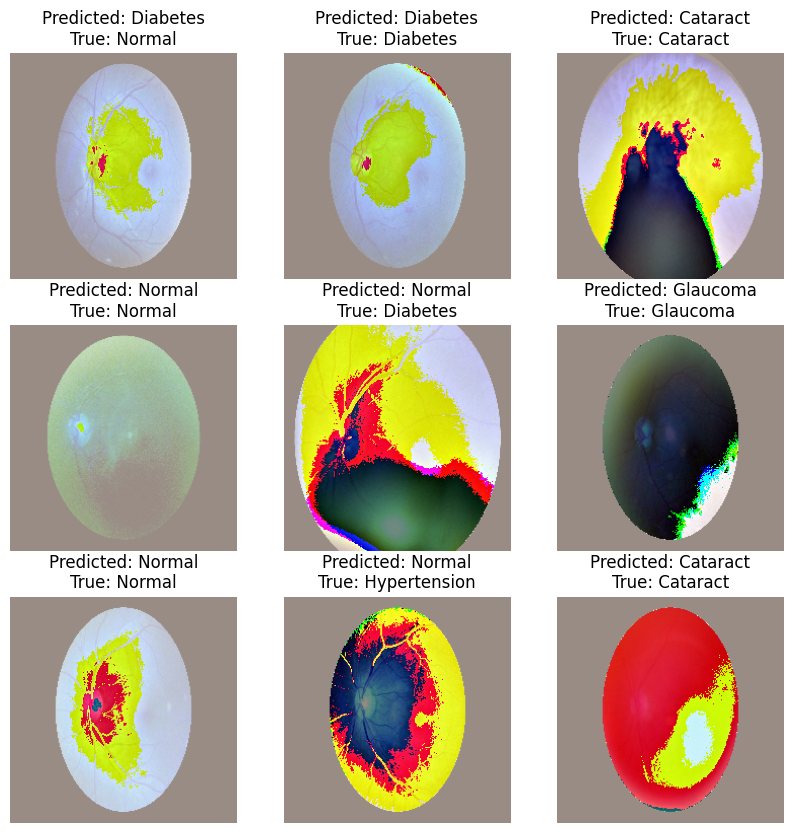

In [26]:
# Evaluate the model on the test dataset
evaluation_results =model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Prediction Evaluation
- Classes normal, diabetes and others are the top 3 predicted classes, this suggests that the remaining classes are underrepresented hence the model is not using them to classify the test data.

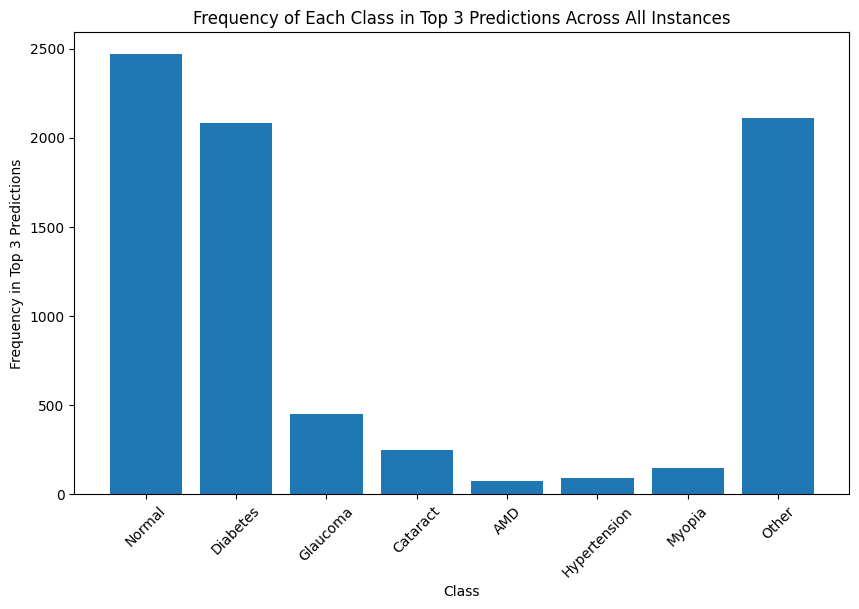

In [27]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [28]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [29]:
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Unbatched label shape: (8,)
Shape of true_labels after vstack: (2558, 8)


In [30]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

                precision    recall  f1-score   support

        Normal       0.58      0.75      0.66      1108
      Diabetes       0.49      0.51      0.50       650
      Glaucoma       0.41      0.36      0.38       114
      Cataract       0.64      0.64      0.64       124
           AMD       0.89      0.17      0.29       100
  Hypertension       1.00      0.05      0.10        56
        Myopia       0.83      0.84      0.84       100
Other diseases       0.30      0.10      0.15       306

      accuracy                           0.55      2558
     macro avg       0.64      0.43      0.44      2558
  weighted avg       0.55      0.55      0.52      2558



Balanced Accuracy Score

In [31]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.4277


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [32]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8260


Confusion Matrix

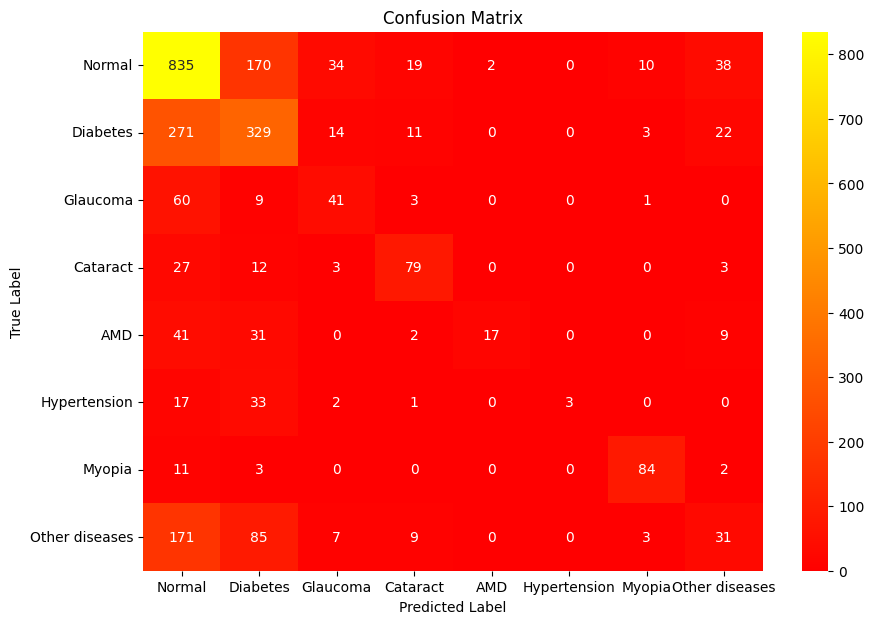

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='autumn', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Explainable AI
- SHAP, GradCAM, LIME

In [ ]:

# Function to load, preprocess images, and prepare labels for SHAP
def parse_image_and_label_for_XAI(image_path, label_string):
    # Load the image file
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [224, 224])
    # Convert image to float32
    image = tf.cast(image, tf.float32)

    # Process the label string into a tensor
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)

    # Return both preprocessed and raw image if necessary for SHAP
    return  image, label


In [ ]:
def load_and_prepare_XAI_dataset(df, images_dir, shuffle=True, batch_size=32):


    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label_for_XAI)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


# Creating training and validation datasets
orig_test_ds = load_and_prepare_XAI_dataset(test_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=True, batch_size=16)

Original Test dataset
(16, 224, 224, 3)
(16, 8)


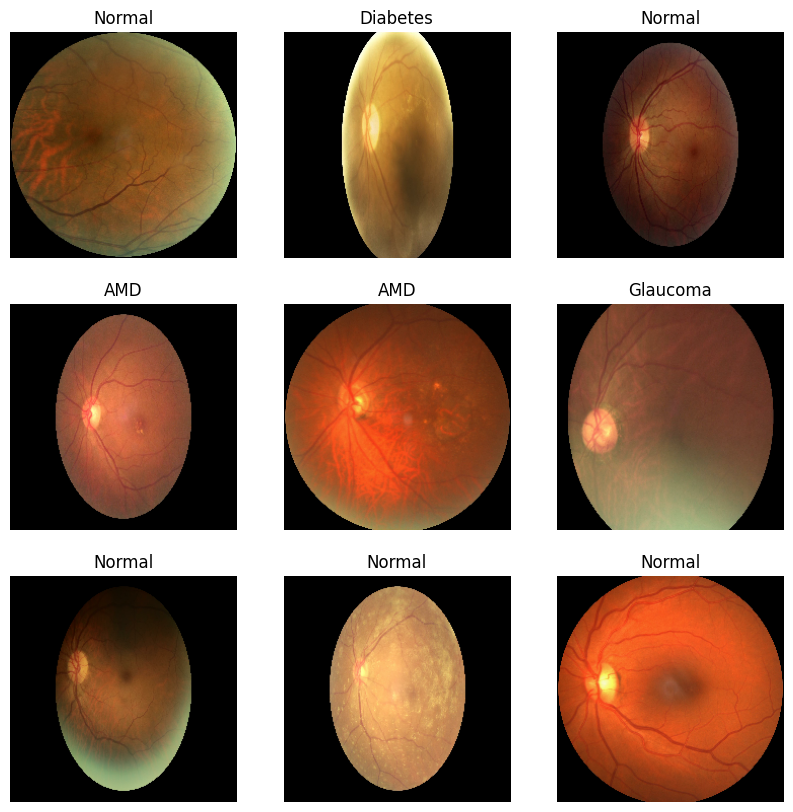

In [ ]:
print("Original Test dataset")
for images, labels in orig_test_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

## LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=1c9f2ea2f676233d8674fec82d68fe7c1b44ae7457eeefdf4c5c2801b9c75e02
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from skimage.segmentation import mark_boundaries
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [ ]:
class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Take one batch from the dataset and extract the first image and its true label
for images_batch, labels_batch in orig_test_ds.take(1):
    image_to_explain = images_batch[0].numpy()
    true_label_index = np.argmax(labels_batch[0].numpy())  # Convert one-hot to index if necessary
    true_label_name = class_names[true_label_index]  # Get the class name using the index

def model_predict(img_batch):
    return model.predict(img_batch)

# Predict the class of the image using the model
prediction = model_predict(images_batch.numpy())

# Explain the prediction using LIME for each of the top classes
explanation = explainer.explain_instance(image_to_explain, model_predict, top_labels=5, hide_color=0, num_samples=1000)

# Create a figure to hold the subplots
fig, axes = plt.subplots(1, 9, figsize=(20, 5))

# For floating-point data
if image_to_explain.dtype == np.float32 or image_to_explain.dtype == np.float64:
    # Normalize the image data to 0-1
    image_to_explain /= np.max(image_to_explain)

# For integer data
elif image_to_explain.dtype == np.uint8:
    # If the data is already in uint8 format, you don't need to scale it
    pass
else:
    # Scale the image data to 0-255 and convert to uint8
    image_to_explain = 255 * (image_to_explain - np.min(image_to_explain)) / (np.max(image_to_explain) - np.min(image_to_explain))
    image_to_explain = image_to_explain.astype(np.uint8)

labels_to_explain = list(range(len(class_names)))  # This will create a list [0, 1, 2, ..., 7]

# Create a figure to hold the subplots
fig, axes = plt.subplots(1, len(class_names) + 1, figsize=(25, 5))  # Adjust for the number of classes plus the original image

# Rest of your code to obtain image_to_explain, true_label_name, etc.

# Find out which labels have explanations
labels_with_explanations = [label for label in labels_to_explain if label in explanation.local_exp]

# Adjust the number of subplots based on the number of labels with explanations
num_explanations = len(labels_with_explanations)
fig, axes = plt.subplots(1, num_explanations + 1, figsize=(5 * (num_explanations + 1), 9))

# Plot the original image with its true class name
axes[0].imshow(image_to_explain)
axes[0].set_title(f'Original: {true_label_name}')

# Index for subplots, starting from 1 since 0 is used by the original image
subplot_index = 1

# Create a mask and plot for each label with an explanation
for label in labels_with_explanations:
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=9, hide_rest=False)
    axes[subplot_index].imshow(mark_boundaries(temp, mask))
    axes[subplot_index].set_title(f'{class_names[label]} Explanation')
    subplot_index += 1

# If there are any remaining axes, remove them
for ax in axes[subplot_index:]:
    ax.remove()

# Remove the axis ticks for a cleaner look
for ax in axes[:subplot_index]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## SHAP

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.9 MB/s eta 0:00:00


In [ ]:
#from tensorflow.keras.applications.resnet50 import  preprocess_input
import shap

In [ ]:
def f(x):
  tmp = x.copy()
  #preprocess_input(tmp)
  return model(tmp)

In [ ]:
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", (224,224,3))

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

In [ ]:
class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Use the take() method to get the first 2 batches from the dataset
batched_dataset = orig_test_ds.take(2)



for images, labels in batched_dataset:
    # Convert EagerTensors to numpy arrays
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

    # Ensure images are in the correct range. This might need adjustment depending on your data.
    numpy_images = numpy_images / 255.0  # Scale to [0, 1] if your images are in the [0, 255] range



In [ ]:

# Calculate SHAP values for your images
shap_values = explainer(numpy_images, max_evals=100, batch_size=9)

# Generate the plot
shap.image_plot(shap_values, numpy_images)

PartitionExplainer explainer:  12%|█▎        | 2/16 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 4/16 [00:17<00:32,  2.72s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 6/16 [00:28<00:41,  4.16s/it]

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 17it [01:22,  5.48s/it]


IndexError: index 1 is out of bounds for axis 0 with size 1

## GradCAM

In [ ]:
import matplotlib.cm as cm
from PIL import Image
from tensorflow.keras.models import Model


In [ ]:
resnet50_submodel = model.get_layer('resnet50')

# Now you can access the layers within the ResNet50 submodel
last_conv_layer = resnet50_submodel.get_layer('conv5_block3_out')

# Print all layer names in the ResNet50 submodel
for layer in resnet50_submodel.layers:
    print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [ ]:

# Access the ResNet50 submodel
resnet50_submodel = model.get_layer('resnet50')

# Access the last convolutional layer of the ResNet50 model
last_conv_layer = resnet50_submodel.get_layer('conv5_block3_out')

# Generate a new model that outputs the final output and the last conv layer output
# Using the input from the main model and the outputs from the submodel and the last conv layer
grad_model = Sequential(inputs=model.input, outputs=[model.output, last_conv_layer.output])

TypeError: Sequential.__init__() got an unexpected keyword argument 'inputs'

In [ ]:
# Assume 'img_array' is the preprocessed image ready to be fed to the model
with tf.GradientTape() as tape:
    # Forward pass
    conv_outputs, predictions = grad_model(img_array)
    # Get the top predicted class
    top_pred_index = tf.argmax(predictions[0])
    # Extract the output of the top predicted class
    top_class_output = predictions[:, top_pred_index]

# Get the gradients of the top predicted class with respect to the outputs of the last conv layer
grads = tape.gradient(top_class_output, conv_outputs)

In [ ]:
# Pool the gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weigh the convolutional layer's output feature maps by the pooled gradients
conv_outputs = conv_outputs[0]
cam = conv_outputs @ pooled_grads[..., tf.newaxis]
cam = tf.squeeze(cam)

In [ ]:
heatmap = tf.maximum(cam, 0) / tf.math.reduce_max(cam)


In [ ]:
# Resize the heatmap to match the original image size
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = Image.fromarray((jet_heatmap * 255).astype(np.uint8))
jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
jet_heatmap = jet_heatmap * 0.4 + original_img

# Save the superimposed image
superimposed_img = Image.fromarray(jet_heatmap)
superimposed_img.save('/path/to/grad_cam.jpg')